In [17]:
import numpy as np

In [18]:
c = np.array([[1,0,0,0,0,0,0,]])
w = np.random.randn(7,3)
h = np.dot(c,w)
print(h)

[[-1.48618104  0.21551717 -0.57530677]]


In [19]:
import sys
sys.path.append('..')
from common.layers import MatMul, SoftmaxWithLoss

c0 = np.array([[1,0,0,0,0,0,0,]])
c1 = np.array([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

In [20]:
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [21]:
def create_contexts_target(corpus, window_size =1):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size +1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

contexts, target = create_contexts_target(corpus, window_size =1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [22]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [23]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V,H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01*np.random.randn(h,V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs =W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1)*0.5
        score = self.out_layer.forward(h)
        loss  = self.loss_layer.forward(score,target)
        return loss

In [24]:
from common.trainer import Trainer
from common.optimizer import Adam 
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

ModuleNotFoundError: No module named 'simple_cbow'

In [ ]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vacab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])


In [ ]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

### ch4

In [ ]:
class Embedding:
    def __init__(self,W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    def forward(self, idx):
            W, = self.params
            self.idx = idx
            out = W[idx]
            return out
    def backward(self, dout):
            dw, = self.grads
            dw[...] = 0
           
            for i , word_id in enumerate(self.idx):
                dw[word_id] += dout[i]
            
            return None

In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    def forward(self, h ,idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        self.cache = (h, target_W)
        return out
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0],1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [ ]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power = 0.75, sample_size = 5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(courpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size +1)]
        self.emped_dot_layers = [EmbeddingDot(W) for _ in range(sample_size +1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_nagetive_sample(target)
        
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)
        
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:,i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_laers[1 + i].forward(score, negative_label)
        return loss   
    
    def backward(self, dout=1):
            dh = 0
            for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
                dscore = l0.backward(dout)
                dh += l1.backward(dscore)
            return dh

In [25]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H  = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out,corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [],[]
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs =W_in

In [28]:
def forward(self, contexts, target):
    h = 0
    for i, layer in enumerate(self.in_layers):
        h += layer.forward(contexts[:, i])
    h *= 1 /len(self.in_layers)
    loss = self.ns_loss.forward(h,target)
    return loss

def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout*= 1/ len(self.in_layers)
        for layer in self.in_layers:
              layer.backward(dout)
        return None

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)
    
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
tainer.plot()

word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs']  =word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id 
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb')as f:
    pickle.dump(params, f, -1)

Done
| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 1[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 2[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 2[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 3[s] | loss 3.93
| epoch 1 |  iter 121 / 9295 | time 3[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 4[s] | loss 3.63
| epoch 1 |  iter 161 / 9295 | time 5[s] | loss 3.48
| epoch 1 |  iter 181 / 9295 | time 5[s] | loss 3.36
| epoch 1 |  iter 201 / 9295 | time 6[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 7[s] | loss 3.14
| epoch 1 |  iter 241 / 9295 | time 7[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 8[s] | loss 3.00
| epoch 1 |  iter 281 / 9295 | time 8[s] | loss 2.95
| epoch 1 |  iter 301 / 9295 | time 9[s] | loss 2.93
| epoch 1 |  iter 321 / 9295 | time 10[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 10[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 11[s] | l

| epoch 1 |  iter 3001 / 9295 | time 94[s] | loss 2.46
| epoch 1 |  iter 3021 / 9295 | time 95[s] | loss 2.47
| epoch 1 |  iter 3041 / 9295 | time 96[s] | loss 2.44
| epoch 1 |  iter 3061 / 9295 | time 96[s] | loss 2.45
| epoch 1 |  iter 3081 / 9295 | time 97[s] | loss 2.45
| epoch 1 |  iter 3101 / 9295 | time 98[s] | loss 2.40
| epoch 1 |  iter 3121 / 9295 | time 98[s] | loss 2.41
| epoch 1 |  iter 3141 / 9295 | time 99[s] | loss 2.42
| epoch 1 |  iter 3161 / 9295 | time 100[s] | loss 2.45
| epoch 1 |  iter 3181 / 9295 | time 100[s] | loss 2.44
| epoch 1 |  iter 3201 / 9295 | time 101[s] | loss 2.42
| epoch 1 |  iter 3221 / 9295 | time 101[s] | loss 2.41
| epoch 1 |  iter 3241 / 9295 | time 102[s] | loss 2.45
| epoch 1 |  iter 3261 / 9295 | time 103[s] | loss 2.41
| epoch 1 |  iter 3281 / 9295 | time 103[s] | loss 2.45
| epoch 1 |  iter 3301 / 9295 | time 104[s] | loss 2.43
| epoch 1 |  iter 3321 / 9295 | time 105[s] | loss 2.46
| epoch 1 |  iter 3341 / 9295 | time 105[s] | loss 2.44


| epoch 1 |  iter 5941 / 9295 | time 188[s] | loss 2.30
| epoch 1 |  iter 5961 / 9295 | time 189[s] | loss 2.31
| epoch 1 |  iter 5981 / 9295 | time 189[s] | loss 2.36
| epoch 1 |  iter 6001 / 9295 | time 190[s] | loss 2.35
| epoch 1 |  iter 6021 / 9295 | time 191[s] | loss 2.33
| epoch 1 |  iter 6041 / 9295 | time 191[s] | loss 2.32
| epoch 1 |  iter 6061 / 9295 | time 192[s] | loss 2.29
| epoch 1 |  iter 6081 / 9295 | time 193[s] | loss 2.33
| epoch 1 |  iter 6101 / 9295 | time 193[s] | loss 2.34
| epoch 1 |  iter 6121 / 9295 | time 194[s] | loss 2.34
| epoch 1 |  iter 6141 / 9295 | time 194[s] | loss 2.30
| epoch 1 |  iter 6161 / 9295 | time 195[s] | loss 2.30
| epoch 1 |  iter 6181 / 9295 | time 196[s] | loss 2.31
| epoch 1 |  iter 6201 / 9295 | time 196[s] | loss 2.29
| epoch 1 |  iter 6221 / 9295 | time 197[s] | loss 2.32
| epoch 1 |  iter 6241 / 9295 | time 198[s] | loss 2.31
| epoch 1 |  iter 6261 / 9295 | time 198[s] | loss 2.36
| epoch 1 |  iter 6281 / 9295 | time 199[s] | lo

| epoch 1 |  iter 8881 / 9295 | time 283[s] | loss 2.24
| epoch 1 |  iter 8901 / 9295 | time 283[s] | loss 2.21
| epoch 1 |  iter 8921 / 9295 | time 284[s] | loss 2.24
| epoch 1 |  iter 8941 / 9295 | time 285[s] | loss 2.24
| epoch 1 |  iter 8961 / 9295 | time 285[s] | loss 2.20
| epoch 1 |  iter 8981 / 9295 | time 286[s] | loss 2.22
| epoch 1 |  iter 9001 / 9295 | time 287[s] | loss 2.21
| epoch 1 |  iter 9021 / 9295 | time 287[s] | loss 2.21
| epoch 1 |  iter 9041 / 9295 | time 288[s] | loss 2.24
| epoch 1 |  iter 9061 / 9295 | time 288[s] | loss 2.25
| epoch 1 |  iter 9081 / 9295 | time 289[s] | loss 2.27
| epoch 1 |  iter 9101 / 9295 | time 290[s] | loss 2.21
| epoch 1 |  iter 9121 / 9295 | time 290[s] | loss 2.26
| epoch 1 |  iter 9141 / 9295 | time 291[s] | loss 2.22
| epoch 1 |  iter 9161 / 9295 | time 292[s] | loss 2.23
| epoch 1 |  iter 9181 / 9295 | time 292[s] | loss 2.20
| epoch 1 |  iter 9201 / 9295 | time 293[s] | loss 2.23
| epoch 1 |  iter 9221 / 9295 | time 294[s] | lo

| epoch 2 |  iter 2541 / 9295 | time 377[s] | loss 2.11
| epoch 2 |  iter 2561 / 9295 | time 378[s] | loss 2.14
| epoch 2 |  iter 2581 / 9295 | time 378[s] | loss 2.17
| epoch 2 |  iter 2601 / 9295 | time 379[s] | loss 2.15
| epoch 2 |  iter 2621 / 9295 | time 380[s] | loss 2.15
| epoch 2 |  iter 2641 / 9295 | time 380[s] | loss 2.10
| epoch 2 |  iter 2661 / 9295 | time 381[s] | loss 2.14
| epoch 2 |  iter 2681 / 9295 | time 382[s] | loss 2.13
| epoch 2 |  iter 2701 / 9295 | time 382[s] | loss 2.13
| epoch 2 |  iter 2721 / 9295 | time 383[s] | loss 2.13
| epoch 2 |  iter 2741 / 9295 | time 384[s] | loss 2.07
| epoch 2 |  iter 2761 / 9295 | time 384[s] | loss 2.16
| epoch 2 |  iter 2781 / 9295 | time 385[s] | loss 2.12
| epoch 2 |  iter 2801 / 9295 | time 386[s] | loss 2.13
| epoch 2 |  iter 2821 / 9295 | time 386[s] | loss 2.13
| epoch 2 |  iter 2841 / 9295 | time 387[s] | loss 2.13
| epoch 2 |  iter 2861 / 9295 | time 387[s] | loss 2.11
| epoch 2 |  iter 2881 / 9295 | time 388[s] | lo

| epoch 2 |  iter 5481 / 9295 | time 471[s] | loss 2.09
| epoch 2 |  iter 5501 / 9295 | time 472[s] | loss 2.07
| epoch 2 |  iter 5521 / 9295 | time 472[s] | loss 2.06
| epoch 2 |  iter 5541 / 9295 | time 473[s] | loss 2.06
| epoch 2 |  iter 5561 / 9295 | time 474[s] | loss 2.08
| epoch 2 |  iter 5581 / 9295 | time 474[s] | loss 2.05
| epoch 2 |  iter 5601 / 9295 | time 475[s] | loss 2.08
| epoch 2 |  iter 5621 / 9295 | time 475[s] | loss 2.06
| epoch 2 |  iter 5641 / 9295 | time 476[s] | loss 2.09
| epoch 2 |  iter 5661 / 9295 | time 477[s] | loss 2.08
| epoch 2 |  iter 5681 / 9295 | time 477[s] | loss 2.05
| epoch 2 |  iter 5701 / 9295 | time 478[s] | loss 2.08
| epoch 2 |  iter 5721 / 9295 | time 479[s] | loss 2.07
| epoch 2 |  iter 5741 / 9295 | time 479[s] | loss 2.04
| epoch 2 |  iter 5761 / 9295 | time 480[s] | loss 2.06
| epoch 2 |  iter 5781 / 9295 | time 481[s] | loss 2.08
| epoch 2 |  iter 5801 / 9295 | time 481[s] | loss 2.07
| epoch 2 |  iter 5821 / 9295 | time 482[s] | lo

| epoch 2 |  iter 8421 / 9295 | time 564[s] | loss 2.05
| epoch 2 |  iter 8441 / 9295 | time 565[s] | loss 2.08
| epoch 2 |  iter 8461 / 9295 | time 566[s] | loss 2.02
| epoch 2 |  iter 8481 / 9295 | time 566[s] | loss 1.99
| epoch 2 |  iter 8501 / 9295 | time 567[s] | loss 2.05
| epoch 2 |  iter 8521 / 9295 | time 568[s] | loss 2.00
| epoch 2 |  iter 8541 / 9295 | time 568[s] | loss 2.00
| epoch 2 |  iter 8561 / 9295 | time 569[s] | loss 1.99
| epoch 2 |  iter 8581 / 9295 | time 570[s] | loss 2.00
| epoch 2 |  iter 8601 / 9295 | time 570[s] | loss 2.04
| epoch 2 |  iter 8621 / 9295 | time 571[s] | loss 2.07
| epoch 2 |  iter 8641 / 9295 | time 571[s] | loss 2.03
| epoch 2 |  iter 8661 / 9295 | time 572[s] | loss 2.00
| epoch 2 |  iter 8681 / 9295 | time 573[s] | loss 2.00
| epoch 2 |  iter 8701 / 9295 | time 573[s] | loss 2.02
| epoch 2 |  iter 8721 / 9295 | time 574[s] | loss 1.98
| epoch 2 |  iter 8741 / 9295 | time 575[s] | loss 2.01
| epoch 2 |  iter 8761 / 9295 | time 575[s] | lo

| epoch 3 |  iter 2081 / 9295 | time 658[s] | loss 1.99
| epoch 3 |  iter 2101 / 9295 | time 659[s] | loss 1.92
| epoch 3 |  iter 2121 / 9295 | time 660[s] | loss 1.94
| epoch 3 |  iter 2141 / 9295 | time 660[s] | loss 1.96
| epoch 3 |  iter 2161 / 9295 | time 661[s] | loss 1.94
| epoch 3 |  iter 2181 / 9295 | time 662[s] | loss 1.96
| epoch 3 |  iter 2201 / 9295 | time 662[s] | loss 1.93
| epoch 3 |  iter 2221 / 9295 | time 667[s] | loss 1.94
| epoch 3 |  iter 2241 / 9295 | time 668[s] | loss 1.90
| epoch 3 |  iter 2261 / 9295 | time 668[s] | loss 1.97
| epoch 3 |  iter 2281 / 9295 | time 669[s] | loss 1.95
| epoch 3 |  iter 2301 / 9295 | time 670[s] | loss 1.92
| epoch 3 |  iter 2321 / 9295 | time 670[s] | loss 1.96
| epoch 3 |  iter 2341 / 9295 | time 671[s] | loss 1.99
| epoch 3 |  iter 2361 / 9295 | time 672[s] | loss 1.94
| epoch 3 |  iter 2381 / 9295 | time 672[s] | loss 1.94
| epoch 3 |  iter 2401 / 9295 | time 673[s] | loss 1.95
| epoch 3 |  iter 2421 / 9295 | time 674[s] | lo

| epoch 3 |  iter 5021 / 9295 | time 757[s] | loss 1.96
| epoch 3 |  iter 5041 / 9295 | time 757[s] | loss 1.93
| epoch 3 |  iter 5061 / 9295 | time 758[s] | loss 1.91
| epoch 3 |  iter 5081 / 9295 | time 759[s] | loss 1.91
| epoch 3 |  iter 5101 / 9295 | time 759[s] | loss 1.91
| epoch 3 |  iter 5121 / 9295 | time 760[s] | loss 1.93
| epoch 3 |  iter 5141 / 9295 | time 761[s] | loss 1.93
| epoch 3 |  iter 5161 / 9295 | time 761[s] | loss 1.91
| epoch 3 |  iter 5181 / 9295 | time 762[s] | loss 1.90
| epoch 3 |  iter 5201 / 9295 | time 763[s] | loss 1.93
| epoch 3 |  iter 5221 / 9295 | time 763[s] | loss 1.91


### ch5

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, wh, b]
        self.grads = [np.zeros_like(Wx),np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    def forward(self, x, h_prev):
            Wx, Wh, b = self.params
            t = np.dot(h_prev, Wh) + np.dot(x, Wx) +b
            h_next = np.tanh(t)
            
            self.cache = (x, h_prev, h_next)
            return h_next

In [2]:
def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next **2)
        db = np.sum(dt, axis = 0)
        dwh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dwx = np.dot(x.t, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, sateful = False):
            self.params = [Wx, Wh, b]
            self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
            self.layers = None
            self.h, self.dh = None, None
            self.sateful = stateful
            
    def set_state(self, h):
            self.h = h
            
    def reset_state(self):
            self.h = None

In [6]:
def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape
    
    self.layers = []
    hs = np.empty((N, T, H), dtype = 'f')
    
    if not self.stateful or self.h is None:
        self.h = np.zeros((N,H), dtype = 'f')
        
    for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t,:], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
    return hs

In [11]:
def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D,H = Wx.shape
        
        dxs = np.empty((N, T,D), dtype ='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
                layer = self.layers[t]
                dx, dh = layer.backward(dhs[:, t, :] + dh)
                dx[:, t, :] = dx
                for i, grad in enumerate(layer.grads):
                        grads[i] += grad
        for i ,grad in enumerate(grads):
                self.grads[i][...] = grad
        self.dh = dh
        return dxs

In [13]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randin
        
        # 重みの初期化
        embed_W = (rn(V,D)/ 100).astype('f')
        rnn_Wx = (rn(D,H)/ np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)/ np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/ np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # すべtの重みと勾配をリストにまとめる
        self.params, self.grads = [],[]
        for layer in self.layers:
                self.params += layer.params
                self.grads += layer.grads

In [14]:
def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
def backward(self, dout = 1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
                dout = layer.backward(dout)
        return dout
def reset_state(self):
        self.rnn_layer.reset_state()

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 398.30
| epoch 2 | perplexity 274.02
| epoch 3 | perplexity 224.20
| epoch 4 | perplexity 216.56
| epoch 5 | perplexity 206.69
| epoch 6 | perplexity 203.28
| epoch 7 | perplexity 197.89
| epoch 8 | perplexity 196.38
| epoch 9 | perplexity 191.93
| epoch 10 | perplexity 192.86
| epoch 11 | perplexity 188.37
| epoch 12 | perplexity 191.77
| epoch 13 | perplexity 189.48
| epoch 14 | perplexity 189.13
| epoch 15 | perplexity 188.31
| epoch 16 | perplexity 184.48
| epoch 17 | perplexity 182.71
| epoch 18 | perplexity 179.65
| epoch 19 | perplexity 180.08
| epoch 20 | perplexity 181.39
| epoch 21 | perplexity 179.33
| epoch 22 | perplexity 175.52
| epoch 23 | perplexity 173.36
| epoch 24 | perplexity 171.71
| epoch 25 | perplexity 172.16
| epoch 26 | perplexity 170.62
| epoch 27 | perplexity 163.21
| epoch 28 | perplexity 162.71
| epoch 29 | perplexity 159.36
| epoch 30 | perplexity 152.61
| epoch 31 | perplexity 155.63
| epoch 

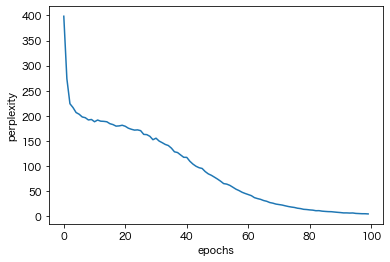

In [22]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()
